In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import json

# Config
BASE_DIR = os.getcwd()  # this gets /.../ml-project-intro/models
data_dir = os.path.abspath(os.path.join(BASE_DIR, '..', 'data'))        # go one level up and into data/
data_dir = os.path.abspath(data_dir) #Normalize the path (resolve '..' correctly)

train_dir = os.path.join(data_dir, 'training')
test_query_dir = os.path.join(data_dir,  'test', 'query')
test_gallery_dir = os.path.join(data_dir, 'test', 'gallery')

batch_size = 64
num_epochs = 5
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [16]:
print(os.path.exists(train_dir))
print(os.listdir(train_dir))  # will list subfolders/classes for training set
print(os.listdir(test_query_dir))

True
['American_chameleon', 'antelope', 'Arctic_fox']
['4597118805213184.jpg', 'n01855672_10973.jpg']


In [17]:
from torch.utils.data import Dataset
from PIL import Image

class ImageDatasetWithoutLabels(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name  # returning image and filename (no label)

import os

class ImageDatasetWithoutLabels(Dataset):
    def __init__(self, folder, transform=None):
        self.image_files = sorted([
            f for f in os.listdir(folder)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        self.folder = folder
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]


In [18]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
# For training data (has subfolders/classes)
train_dataset = datasets.ImageFolder(train_dir, data_transforms['train'])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# For query data (NO subfolders/classes)
query_dataset = ImageDatasetWithoutLabels(test_query_dir, transform=data_transforms['test'])
query_loader = DataLoader(query_dataset, batch_size=batch_size, shuffle=False)

# For gallery data (depends on structure)
# Option 1: If gallery has subfolders/classes
gallery_dataset = ImageDatasetWithoutLabels(test_gallery_dir, data_transforms['test'])
gallery_loader = DataLoader(gallery_dataset, batch_size=batch_size, shuffle=False)


def get_test_loader(dir_path):
    dataset = datasets.ImageFolder(dir_path, data_transforms['test'])
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return loader

query_dataset = ImageDatasetWithoutLabels(test_query_dir, transform=data_transforms['test'])
query_loader = DataLoader(query_dataset, batch_size=batch_size, shuffle=False)



In [19]:
def initialize_model(pretrained=True, feature_extract=True):
    model = models.resnet18(pretrained=pretrained)

    if feature_extract:
        # For feature extraction, keep the backbone and remove the classification head
        model.fc = nn.Identity()

    return model.to(device)


In [20]:
def train_model(model, dataloader, num_epochs=20, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {running_loss / len(dataloader):.4f}")

def fine_tune_model(model, num_classes):
    # Check if model.fc is a Sequential block or a single Linear layer
    if isinstance(model.fc, nn.Sequential):
        num_features = model.fc[0].in_features  # Extract from first layer in Sequential
    else:
        num_features = model.fc.in_features

    # Replace with a new Sequential block for classification
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, num_classes)
    ).to(device)

    return model




In [21]:
def extract_features(model, loader):
    model.eval()
    features = []
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
    return np.vstack(features)

def calculate_similarity(query_features, gallery_features):
    similarities = cosine_similarity(query_features, gallery_features)
    return similarities


In [22]:
def get_all_images(dataloader):
    all_images = []
    for images, _ in dataloader:
        all_images.append(images.cpu())
    return torch.cat(all_images, dim=0)

def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return (img_tensor * std + mean).clamp(0, 1)

In [23]:
def calculate_accuracy(similarities, k=10):
    correct = 0
    for i, query_sim in enumerate(similarities):
        top_k_indices = np.argsort(query_sim)[-k:][::-1]
        if i in top_k_indices:
            correct += 1
    accuracy = correct / len(similarities)
    print(f"Top-{k} Accuracy: {accuracy:.4f}")
    return accuracy


def visualize_retrieved_images(query_loader, gallery_loader, similarities, k=10):
    query_images = get_all_images(query_loader)
    gallery_images = get_all_images(gallery_loader)

    for i, query_sim in enumerate(similarities):
        top_k_indices = np.argsort(query_sim)[-k:][::-1]
        plt.figure(figsize=(10, 2))
        plt.subplot(1, k + 1, 1)
        plt.imshow(denormalize(query_images[i]).permute(1, 2, 0))
        plt.title("Query")
        plt.axis('off')
        for j, idx in enumerate(top_k_indices):
            plt.subplot(1, k + 1, j + 2)
            plt.imshow(denormalize(gallery_images[idx]).permute(1, 2, 0))
            plt.title(f"Top {j+1}")
            plt.axis('off')
        plt.show()

c:\Users\MyPc\anaconda3\envs\ML_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MyPc\anaconda3\envs\ML_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 - Loss: 1.1724
Epoch 2/5 - Loss: 0.3252
Epoch 3/5 - Loss: 0.0541
Epoch 4/5 - Loss: 0.0166
Epoch 5/5 - Loss: 0.0047
Top-10 Accuracy: 1.0000


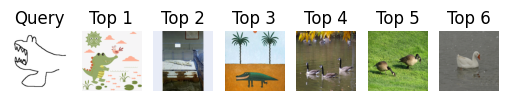

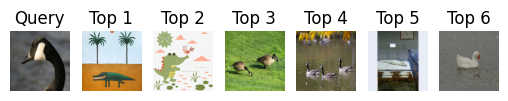

In [24]:
# Fine-tune model with classification head
model = initialize_model(pretrained=True, feature_extract=False)
num_classes = len(train_dataset.classes)
model = fine_tune_model(model, num_classes=num_classes)
train_model(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate)

# Prepare model for feature extraction by removing classification head
model.fc = nn.Identity()

# Extract features for query and gallery images
query_features = extract_features(model, query_loader)
gallery_features = extract_features(model, gallery_loader)


# Calculate similarity and evaluate
similarities = calculate_similarity(query_features, gallery_features)
calculate_accuracy(similarities, k=10)
visualize_retrieved_images(query_loader, gallery_loader, similarities, k=10)


In [27]:
import os
import json
from datetime import datetime

def save_metrics_json(model_name, top_k_accuracy, batch_size, is_finetuned, num_classes=None, runtime=None):
    timestamp = datetime.now().strftime("%Y%m%d-%H%M")

    metrics = {
        "model_name": model_name,
        "run_id": timestamp,
        "top_k": 10,
        "top_k_accuracy": round(top_k_accuracy, 4),
        "batch_size": batch_size,
        "is_finetuned": is_finetuned,
        "num_classes": num_classes,
        "runtime_seconds": round(runtime, 2) if runtime else None
    }

    # Save to the root-level "results" folder (same level as "models")
    project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
    results_dir = os.path.join(project_root, "results")
    os.makedirs(results_dir, exist_ok=True)

    out_path = os.path.join(results_dir, f"{model_name}_metrics_{timestamp}.json")

    with open(out_path, "w") as f:
        json.dump(metrics, f, indent=2)
    
    print(f"📁 Metrics saved to: {out_path}")


In [28]:
import time
start_time = time.time()

# 1. Compute similarities and top-k indices
similarities = calculate_similarity(query_features, gallery_features)
K = 10
I = np.argsort(similarities, axis=1)[:, -K:][:, ::-1]

# 2. Extract file names from datasets
query_paths = [os.path.join(test_query_dir, name) for name in query_dataset.image_files]
gallery_paths = [os.path.join(test_gallery_dir, name) for name in gallery_dataset.image_files]

# 3. Build submission format
submission = []
for qi, qpath in enumerate(query_paths):
    qname = os.path.basename(qpath)
    retrieved = [os.path.basename(gallery_paths[i]) for i in I[qi]]
    submission.append({
        "filename": qname,
        "samples": retrieved
    })

# 4. Write the JSON file
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
out_path = os.path.join(base_dir, "submissions", "sub_resnet2.json")
os.makedirs(os.path.dirname(out_path), exist_ok=True)

with open(out_path, "w") as f:
    json.dump(submission, f, indent=2)

print(f"✅ Done! {len(submission)} queries written to {out_path}")

# 5. Compute top-k accuracy
top_k_acc = calculate_accuracy(similarities, k=K)

# 6. Save metrics to file
runtime = time.time() - start_time

save_metrics_json(
    model_name="resnet18", 
    top_k_accuracy=top_k_acc,
    batch_size=batch_size,
    is_finetuned=True,  # Set to False if the model was not fine-tuned
    num_classes=len(train_dataset.classes),
    runtime=runtime
)


✅ Done! 2 queries written to c:\Users\MyPc\OneDrive\Documenti\Universita\Data Science\Intro to ML\Competition\ml-project-intro\submissions\sub_resnet2.json
Top-10 Accuracy: 1.0000
📁 Metrics saved to: c:\Users\MyPc\OneDrive\Documenti\Universita\Data Science\Intro to ML\Competition\ml-project-intro\results\resnet18_metrics_20250522-1542.json
